In [1]:
import pandas as pd
import numpy as np
from pyproj import CRS
from pyproj import Transformer
import time
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [10]:
def optimized_function_maid(df, lat_col='latitude', lon_col='longitude', datetime_col='datetime', maid_col='maid'):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.sort_values(by=[maid_col, datetime_col, lat_col,lon_col])

    # Shift columns to get previous values for each maid
    df['prev_X'] = df.groupby(maid_col)[lon_col].shift(1)
    df['prev_Y'] = df.groupby(maid_col)[lat_col].shift(1)
    df['prev_datetime'] = df.groupby(maid_col)[datetime_col].shift(1)

    # Radius of the Earth in kilometers
    R = 6371

    # Convert latitude and longitude from degrees to radians
    lat1 = np.radians(df[lat_col].values)
    lat2 = np.radians(df['prev_Y'].values)
    dlat = lat2 - lat1
    dlon = np.radians(df['prev_X'].values) - np.radians(df[lon_col].values)

    # Haversine formula for distance calculation
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # Calculate consecutive distance in kilometers
    df['consecutive_distance(kms)'] = R * c
    df['cumulative_distance(kms)'] = df.groupby(maid_col)['consecutive_distance(kms)'].cumsum()

    # Calculate consecutive time gap in minutes
    df['consecutive_time_gap(minutes)'] = (df[datetime_col] - df['prev_datetime']).dt.total_seconds() / 60

    # Calculate cumulative time in minutes
    df['cumulative_time(minutes)'] = df.groupby(maid_col)['consecutive_time_gap(minutes)'].cumsum()


    df['Instantaneous_speed(km/h)'] = df['consecutive_distance(kms)'] / (df['consecutive_time_gap(minutes)'] / 60)
    
    # Drop temporary columns
    df = df.drop(columns=['prev_X', 'prev_Y', 'prev_datetime'])

    # Fill NaN values with 0
    df = df.fillna(0)

    return df

In [5]:
# df_districts= pd.read_csv(r'C:\Users\User\Downloads\Mobility_traces_new_data_code\records_with_districts\df_useful_with_districts_cleaned_latest.csv')
df_good_and_bad = pd.read_csv(r'C:\Users\User\Downloads\Mobility_traces_new_data_code\Position_time_plots\good_and_bad_raw_data.csv')

In [8]:
df_good_and_bad.columns

Index(['maid', 'EVENT_DATE', 'latitude', 'longitude', 'accuracy', 'device_os',
       'datetime', 'date', 'time'],
      dtype='object')

In [12]:
df_good_and_bad = optimized_function_maid(df_good_and_bad)
df_good_and_bad.shape

(27938, 14)

In [13]:
# result_df_uttarakhand.to_csv(r'C:\Users\User\Downloads\Mobility_traces_new_data_code\distance_vs_time\result_df_uttarakhand.csv')
df_good_and_bad.to_csv(r'C:\Users\User\Downloads\Mobility_traces_new_data_code\Position_time_plots\good_and_bad_raw_data_with_distance.csv', index=False)

In [39]:
# Function to plot cumulative distance
def plot_cumulative_distance(df, prefix=''):
    """
    Plots the cumulative distance against cumulative time for each maid in the dataframe.

    Parameters:
    df (pd.DataFrame): DataFrame containing maid, datetime, cumulative_distance(kms).
    """

    # Check and convert the datetime column if necessary
    if not pd.api.types.is_datetime64_any_dtype(df['datetime']):
        df['datetime'] = pd.to_datetime(df['datetime'])

    # Plotting cumulative distance against cumulative time
    plt.figure(figsize=(12, 6))

    for maid, group in df.groupby('maid'):
        plt.plot(group['datetime'], group['cumulative_distance(kms)'], marker='o', linestyle='-', label=maid)

    plt.xlabel('Date')
    plt.ylabel('Distance (Kms)')

    # Adjusting the legend position and appearance
    plt.legend(
        loc='upper left',
        title='Maid ID',
        fancybox=True,
        framealpha=0.5,
        borderpad=1
    )

    plt.title(f'{prefix}Cumulative Distance vs Time')

    # Set the x-axis major locator to day and format the dates
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    # ax.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
    # ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))


    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot the cumulative distance vs time using the sample data
# plot_cumulative_distance(df)


In [3]:
def save_groups_to_folder(base_directory, new_folder_name, df, prefix=''):
    """
    Saves each group of a DataFrame to CSV files in a new folder within the base directory.

    Parameters:
    base_directory (str): Base directory path where the new folder should be created.
    new_folder_name (str): Name of the new folder to be created within the base directory.
    df (pd.DataFrame): DataFrame containing data to be grouped and saved.
    """
    # Full path to the new folder
    new_folder_path = os.path.join(base_directory, new_folder_name)

    # Create the new folder if it doesn't exist
    os.makedirs(new_folder_path, exist_ok=True)

    # Group the DataFrame by 'DEVICE_ID'
    # device_groups = df.groupby('DEVICE_ID')

    device_groups = df.groupby('maid')

    # Save each group to a CSV file in the new folder
    for device_id, group in device_groups:
        filename = f"{prefix}Uttarakhand_{device_id}.csv"
        filepath = os.path.join(new_folder_path, filename)
        group.to_csv(filepath, index=False)
        print(f"Saved records for device {device_id} to {filepath}")

In [24]:
import json
with open(r'C:\Users\User\Downloads\Mobility_traces_new_data_code\Position_time_plots\IDs_for_bad_plots.json', 'r') as f:
    bad_ids = json.load(f)

with open(r'C:\Users\User\Downloads\Mobility_traces_new_data_code\Position_time_plots\IDs_for_good_plots.json', 'r') as f:
    good_ids = json.load(f)

In [16]:
import os
import pandas as pd

def save_files_to_folder(base_directory, df, prefix=''):
    """
    Saves each group of a DataFrame to CSV files in the base directory.

    Parameters:
    base_directory (str): Base directory path where the CSV files should be saved.
    df (pd.DataFrame): DataFrame containing data to be grouped and saved.
    """
    # Group the DataFrame by 'maid'
    device_groups = df.groupby('maid')

    # Save each group to a CSV file in the base directory
    for device_id, group in device_groups:
        filename = f"{prefix}Uttarakhand_{device_id}.csv"
        filepath = os.path.join(base_directory, filename)
        group.to_csv(filepath, index=False)
        print(f"Saved records for device {device_id} to {filepath}")

# Example usage:
# Assuming you have a DataFrame 'df' and a directory 'base_directory'
# save_groups_to_folder('path/to/base_directory', df, prefix='example_prefix_')


In [33]:
# base_directory = r'C:\Users\User\Downloads\Mobility_traces_new_data_code\distance_vs_time\sample_ids' 
base_directory = r'C:\Users\User\Downloads\Mobility_traces_new_data_code\Position_time_plots\good ones' 

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os

# # Sample data for demonstration
# data = {
#     'maid': ['id1', 'id1', 'id2', 'id2', 'id3', 'id3', 'id4', 'id4', 'id5', 'id5', 'id6', 'id6'],
#     'datetime': pd.date_range(start='2022-09-01', periods=12, freq='D'),
#     'cumulative_distance(kms)': [10, 20, 5, 15, 0, 10, 12, 24, 6, 12, 10, 20]
# }
# df = pd.DataFrame(data)

# # Sample bad_IDs list
# bad_IDs = ['id1', 'id2', 'id3', 'id4', 'id5', 'id6', 'id7', 'id8', 'id9', 'id10']

# Function to plot cumulative distance and save the figure
def plot_cumulative_distance_1(df, output_path, prefix=''):
    """
    Plots the cumulative distance against cumulative time for each maid in the dataframe and saves the figure.

    Parameters:
    df (pd.DataFrame): DataFrame containing maid, datetime, cumulative_distance(kms).
    output_path (str): Path to save the figure.
    """
    # Plotting cumulative distance against cumulative time
    plt.figure(figsize=(12, 6))

    for maid, group in df.groupby('maid'):
        plt.plot(group['datetime'], group['cumulative_distance(kms)'], marker='o', linestyle='-', label=maid)

    plt.xlabel('Date')
    plt.ylabel('Distance (Kms)')

    # Adjusting the legend position and appearance
    plt.legend(
        loc='upper left',
        title='Maid ID',
        fancybox=True,
        framealpha=0.5,
        borderpad=1
    )

    plt.title(f'{prefix} Cumulative Distance vs Time')

    # Set the x-axis major locator to day and format the dates
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    # ax.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
    # ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))

    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()

    # Save the figure
    plt.savefig(output_path)
    plt.close()
    print(f"Plot saved as {output_path}")

# Function to process bad_IDs in batches of 5 and plot cumulative distance
def process_and_plot_bad_ids(df, bad_IDs, output_folder, prefix=''):
    os.makedirs(output_folder, exist_ok=True)
    for i in range(0, len(bad_IDs), 5):
        batch_ids = bad_IDs[i:min(i+5, len(bad_IDs))]
        batch_df = df[df['maid'].isin(batch_ids)]
        batch_df['datetime']=pd.to_datetime(batch_df['datetime'])
        output_path = os.path.join(output_folder, f'{prefix}_distance_plot_{i//5 + 1}.png')
        plot_cumulative_distance_1(batch_df, output_path, prefix=f'raw_good: {i//5 + 1} ')

# # Example usage
# output_folder = r'C:\Users\User\Downloads\Mobility_traces_new_data_code\Position_time_plots\Problematic'
# prefix = 'raw_bad'
# process_and_plot_bad_ids(df_good_and_bad, bad_ids, output_folder, prefix)


In [18]:
data_with_states = pd.read_csv(r'C:\Users\User\Downloads\Mobility_traces_new_data_code\all visitors\visitors_with_all_states_and_districts.csv')
data_with_states.shape

(3729555, 11)

In [ ]:
# Example usage
output_folder = r'C:\Users\User\Downloads\Mobility_traces_new_data_code\Position_time_plots\Problematic'
prefix = 'processed_bad'
process_and_plot_bad_ids(data_with_states, bad_ids, output_folder, prefix)

In [51]:
# Example usage
output_folder = r'C:\Users\User\Downloads\Mobility_traces_new_data_code\Position_time_plots\good ones'
prefix = 'raw_good'
process_and_plot_bad_ids(df_good_and_bad, good_ids, output_folder, prefix)

C:\Users\Admin\AppData\Local\Temp\ipykernel_28884\2850123057.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df['datetime']=pd.to_datetime(batch_df['datetime'])


Plot saved as C:\Users\User\Downloads\Mobility_traces_new_data_code\Position_time_plots\good ones\raw_good_distance_plot_1.png
Plot saved as C:\Users\User\Downloads\Mobility_traces_new_data_code\Position_time_plots\good ones\raw_good_distance_plot_2.png


C:\Users\Admin\AppData\Local\Temp\ipykernel_28884\2850123057.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df['datetime']=pd.to_datetime(batch_df['datetime'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_28884\2850123057.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df['datetime']=pd.to_datetime(batch_df['datetime'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_28884\2850123057.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

Plot saved as C:\Users\User\Downloads\Mobility_traces_new_data_code\Position_time_plots\good ones\raw_good_distance_plot_3.png
Plot saved as C:\Users\User\Downloads\Mobility_traces_new_data_code\Position_time_plots\good ones\raw_good_distance_plot_4.png


C:\Users\Admin\AppData\Local\Temp\ipykernel_28884\2850123057.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df['datetime']=pd.to_datetime(batch_df['datetime'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_28884\2850123057.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_df['datetime']=pd.to_datetime(batch_df['datetime'])


Plot saved as C:\Users\User\Downloads\Mobility_traces_new_data_code\Position_time_plots\good ones\raw_good_distance_plot_5.png
Plot saved as C:\Users\User\Downloads\Mobility_traces_new_data_code\Position_time_plots\good ones\raw_good_distance_plot_6.png


8b76da47-b014-4cf5-923c-0105e0d0b40e
5074f72a-cac2-4aec-82ea-8d89e3801eb1
6be75fc9-2467-4f82-8e1d-c2dfde85b22e
12a54fd9-445d-4565-acf5-2ad93edec533
44e6967f-aa2e-45c6-8f05-405b68b9fe97


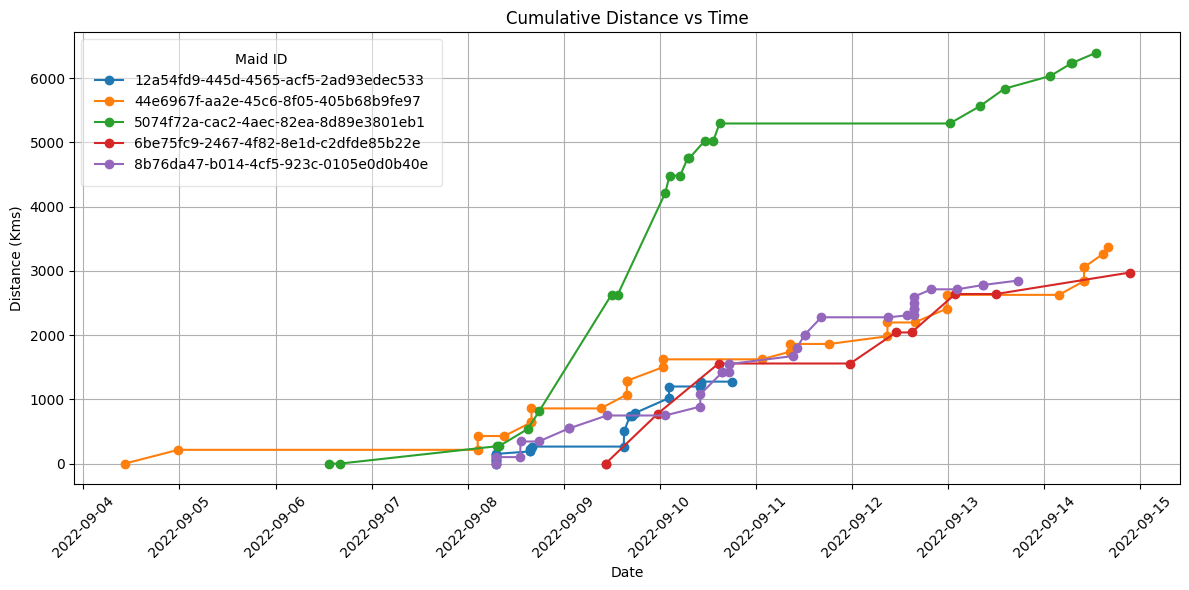

In [34]:
sample_ids = result_df_uttarakhand['maid'].sample(n=5, random_state=2).tolist()
sample_df= result_df_uttarakhand[result_df_uttarakhand['maid'].isin(set(sample_ids))]
print('\n'.join(map(str, sample_ids)))
plot_cumulative_distance(sample_df)

In [20]:
# save_groups_to_folder(base_directory, '0',sample_df)

02a2c301-fb8c-4657-a346-a60fd50754d5
0324c96e-0bc2-4e04-bcce-b419eed987f2
065d43c1-ac1e-4317-8f94-506c362dd6d2
077cf1d9-9c61-43ed-b558-f0d4e4eca5e2
07e64e26-256d-4ca0-85cd-1f112cee7220


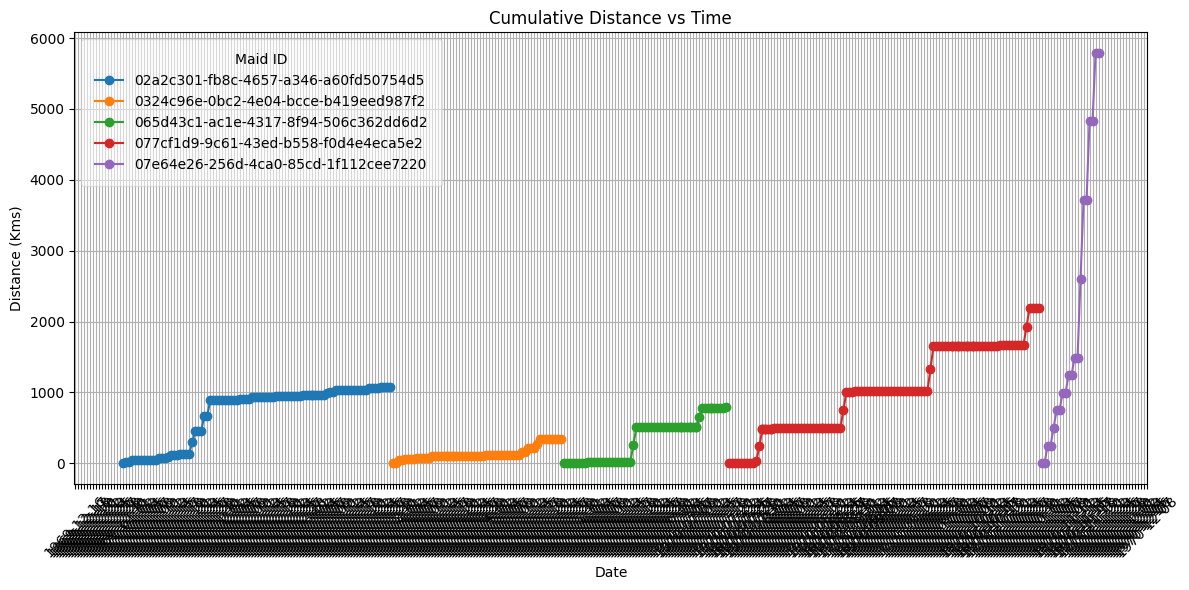

Files and figure were not saved.


In [40]:
from IPython.display import clear_output

while True:
    user_input = input("Enter 'x' to exit or enter any seed to continue: ")
    
    if user_input.lower() == 'x':
        break
    
    try:
        seed = int(user_input)
    except ValueError:
        print("Invalid input. Please enter a valid integer seed or 'x' to exit.")
        continue

    # sample_ids = data_with_states['maid'].sample(n=5, random_state=seed).tolist()
    sample_df = data_with_states[data_with_states['maid'].isin(set(bad_ids[0:5]))]
    print('\n'.join(map(str, bad_ids[0:5])))
    
    plot_cumulative_distance(sample_df)
    
    save_files_input = input("Do you want to save the files and figure? Enter 'y' for yes or 'n' for no: ").lower()
    
    if save_files_input == 'y':
        save_groups_to_folder(base_directory, user_input, sample_df)
        plt.savefig(f"{base_directory}/figure_{user_input}.png")
        print("Files and figure were saved.")
    elif save_files_input == 'n':
        print("Files and figure were not saved.")
    else:
        print("Invalid input. Files and figure were not saved.")
    
    clear_output(wait=True)


In [54]:
# result_df_uttarakhand[result_df_uttarakhand['maid']=='40365d36-d3b2-4e60-9183-1745e2f848ca']
import os
import glob
import json

def get_csv_files(base_directory):
    # Get list of all CSV files in the directory and subdirectories
    csv_files = glob.glob(os.path.join(base_directory, '**', '*.csv'), recursive=True)
    return csv_files

base_directory = r'C:\Users\User\Downloads\Mobility_traces_new_data_code\distance_vs_time'  # Change this to your directory
csv_files = get_csv_files(base_directory)
print(len(csv_files))
# Print the names of all CSV files
# for csv_file in csv_files:
#     print(csv_file)
# csv_files[0].split('Uttarakhand_')[1]
visitors = []
for i in range(len(csv_files)):
    try:
        temp_str = csv_files[i].split('Uttarakhand_')[1]
        temp_str = temp_str.split('.csv')[0]
        print(temp_str)
        visitors.append(temp_str)
    except:
        pass
print(len(visitors))
visitors= set(visitors)
print(len(visitors))
with open(r'C:\Users\User\Downloads\Mobility_traces_new_data_code\distance_vs_time\sample_ids\Issue IDS\issue_ids.json','w') as f:
    json.dump(list(visitors),f)

106
00b42e0a-1fb7-4485-b665-f64c60cb3a5b
065d43c1-ac1e-4317-8f94-506c362dd6d2
2080b4bf-f848-482e-ae98-801d531f5105
2513c9f6-fbc4-4f79-ae6f-c0d5f829703c
389fc105-f10a-4d5a-8b51-f6d04f6270e1
3a0b9a0d-826f-4df3-bcfe-d555f4422fac
4e777aec-0beb-473f-8e3f-43526010f3dc
586225c2-df00-4d50-b8b0-30bfe7286a42
5c3408c5-7293-475b-9e45-469ce3aeb4d5
812489a1-a828-4f9c-80e2-124a1884ba96
8d29345e-0798-4336-a551-7492e11ceeea
93abb9da-838c-4380-ae7b-832829a83d45
aeb8da0a-5ec5-4672-ab7e-661fd3e3141c
bbfcae81-2bc7-47d2-b2dc-4e9babf15c20
f39c7cec-c16a-43f4-866a-fa0b81127177
40365d36-d3b2-4e60-9183-1745e2f848ca
455bf269-6a99-4666-899f-9e27fc6e53f9
45648352-2425-4dae-a723-704855deeb80
8ec1cd14-1903-4f8d-b2ae-99e29f4f9cc1
bacbbf25-c927-4849-8066-d514cf4180eb
2513c9f6-fbc4-4f79-ae6f-c0d5f829703c
586225c2-df00-4d50-b8b0-30bfe7286a42
8d29345e-0798-4336-a551-7492e11ceeea
93abb9da-838c-4380-ae7b-832829a83d45
aeb8da0a-5ec5-4672-ab7e-661fd3e3141c
4ea9990b-f756-41f0-9e11-5dfba90d9002
594da83d-a38a-400d-8885-8f2912428a

In [55]:
path= r'C:\Users\User\Downloads\Mobility_traces_new_data_code\filtered_records\For sample IDs'
files_paths=[]
x_f=[]
for root, dirs, files in os.walk(path):
            # print(f'\nProcessing directory: {root}')
            file = [os.path.join(root, f) for f in files if f.endswith('.csv')]
            x= [f for f in files if f.endswith('.csv')]
            files_paths.extend(file)
            x_f.extend(x)
print(files_paths)
print(len(files_paths))

['C:\\Users\\User\\Downloads\\Mobility_traces_new_data_code\\filtered_records\\For sample IDs\\filtered_records_20240708_092834\\total_visitors_New data -20240605T045959Z-001.csv', 'C:\\Users\\User\\Downloads\\Mobility_traces_new_data_code\\filtered_records\\For sample IDs\\filtered_records_20240708_092906\\total_visitors_New data -20240605T045959Z-002.csv', 'C:\\Users\\User\\Downloads\\Mobility_traces_new_data_code\\filtered_records\\For sample IDs\\filtered_records_20240708_093000\\total_visitors_New data -20240605T045959Z-003.csv', 'C:\\Users\\User\\Downloads\\Mobility_traces_new_data_code\\filtered_records\\For sample IDs\\filtered_records_20240708_093050\\total_visitors_New data -20240605T045959Z-004.csv', 'C:\\Users\\User\\Downloads\\Mobility_traces_new_data_code\\filtered_records\\For sample IDs\\filtered_records_20240708_093136\\total_visitors_New data -20240605T045959Z-005.csv', 'C:\\Users\\User\\Downloads\\Mobility_traces_new_data_code\\filtered_records\\For sample IDs\\filte

In [56]:
raw_data_traces_sample_ids_list =[]
for i in files_paths:
    df_raw = pd.read_csv(i)
    selected_rec= df_raw[df_raw['maid'].isin(set(visitors))]
    raw_data_traces_sample_ids_list.append(selected_rec)

sum = 0
for i in raw_data_traces_sample_ids_list:
    sum+=len(i)
print(f'total stamps ={sum}')

total stamps =24238


In [67]:
# sample_id_raw_traces = pd.concat(raw_data_traces_sample_ids_list)
# sample_id_raw_traces.shape
# sample_id_raw_traces.columns
# sample_id_raw_traces['datetime'] = pd.to_datetime(sample_id_raw_traces['datetime'])
# sample_id_raw_traces['datetime'].dtype
sample_id_raw_traces.sort_values(by=['maid','datetime','latitude','longitude'])
sample_id_raw_traces.to_csv(r'C:\Users\User\Downloads\Mobility_traces_new_data_code\distance_vs_time\sample_dfs_raw_data\sample_id_raw_traces.csv')

In [64]:
sample_id_raw_traces.shape  #(24238, 4)

(24238, 4)

In [66]:
sample_id_raw_traces = optimized_function_maid(sample_id_raw_traces)
sample_id_raw_traces.shape #(24238, 9)

(24238, 9)

d5151163-8025-4a45-9660-1d38d601667e
eed91cdc-6842-4676-91f8-f3bb3c708b17
02262fee-6c8a-4899-94dd-25f47b101f00
4d6a1ae4-6de9-462b-99a9-1951f97f5e78
ca901d31-7682-4191-bef3-0b634d7148ea


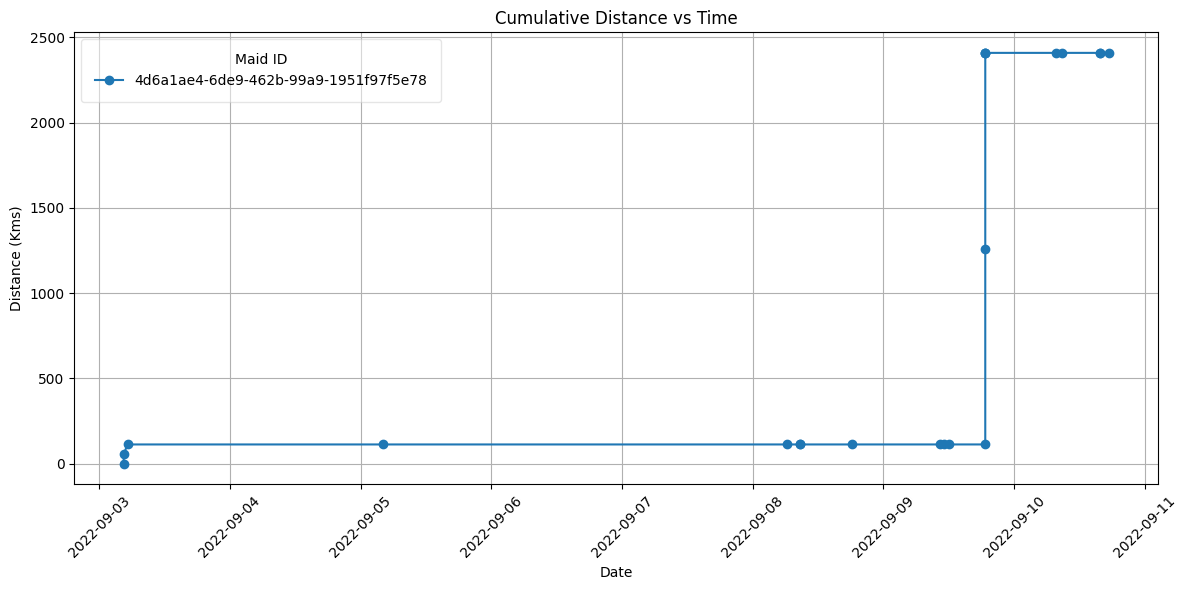

Saved records for device 4d6a1ae4-6de9-462b-99a9-1951f97f5e78 to C:\Users\User\Downloads\Mobility_traces_new_data_code\distance_vs_time\sample_ids\24\From_useful_Uttarakhand_4d6a1ae4-6de9-462b-99a9-1951f97f5e78.csv
Files and figure were saved.


In [42]:
from IPython.display import clear_output

while True:
    user_input = input("Enter 'x' to exit or enter any seed to continue: ")
    
    if user_input.lower() == 'x':
        break
    
    try:
        seed = int(user_input)
    except ValueError:
        print("Invalid input. Please enter a valid integer seed or 'x' to exit.")
        continue

    # sample_ids = result_df_uttarakhand['maid'].sample(n=5, random_state=seed).tolist()
    # sample_df = result_df_uttarakhand[result_df_uttarakhand['maid'].isin(set(sample_ids))]
    
    sample_df = result_df_uttarakhand[result_df_uttarakhand['maid'].str.contains('4d6a1ae4-6de9', na=False)]
    # sample_ids = sample_id_raw_traces['maid'].sample(n=5, random_state=seed).tolist()
    # sample_df_processed = result_df_uttarakhand[result_df_uttarakhand['maid'].isin(set(sample_ids))]
    # sample_df_raw = sample_id_raw_traces[sample_id_raw_traces['maid'].isin(set(sample_ids))]
    print('\n'.join(map(str, sample_ids)))
    
    plot_cumulative_distance(sample_df, '')
    # plot_cumulative_distance(sample_df_processed, 'Processed: ')
    # plot_cumulative_distance(sample_df_raw, 'Raw: ')
    
    save_files_input = input("Do you want to save the files and figure? Enter 'y' for yes or 'n' for no: ").lower()
    
    if save_files_input == 'y':
        save_groups_to_folder(base_directory, user_input, sample_df, 'From_useful_')
        # save_groups_to_folder(base_directory, user_input, sample_df_raw, 'Raw_')
        # save_groups_to_folder(base_directory, user_input, sample_df_processed, 'Processed_')
        # plt.savefig(f"{base_directory}/figure_{user_input}.png")
        print("Files and figure were saved.")
    elif save_files_input == 'n':
        print("Files and figure were not saved.")
    else:
        print("Invalid input. Files and figure were not saved.")
    
    clear_output(wait=True)
